In [1]:
import torch
import numpy as np

# 张量 Tensor

## Tensor初始化

In [2]:
x_data = torch.tensor([[1, 2], [3, 4]])
x_data

tensor([[1, 2],
        [3, 4]])

In [3]:
x_np = torch.tensor(np.array([[1, 2], [3, 4]]))
x_np

tensor([[1, 2],
        [3, 4]], dtype=torch.int32)

In [4]:
x_ones = torch.ones_like(x_np)  # 保留了x_np的各种特征
x_ones

tensor([[1, 1],
        [1, 1]], dtype=torch.int32)

In [5]:
x_rand = torch.rand_like(x_np, dtype=torch.float)  # 指定新类型
x_rand

tensor([[0.1350, 0.1078],
        [0.4673, 0.7140]])

In [6]:
shape = (2, 3)
torch.rand(shape), torch.zeros(shape)

(tensor([[0.3121, 0.6120, 0.0336],
         [0.8718, 0.3489, 0.4999]]),
 tensor([[0., 0., 0.],
         [0., 0., 0.]]))

## Tensor的属性

In [7]:
tensor = torch.randn(3, 4)
print(tensor.shape)
print(tensor.dtype)
print(tensor.device)

torch.Size([3, 4])
torch.float32
cpu


## Tensor运算

In [8]:
# Tensor是可以在GPU上加速的ndarray
if torch.cuda.is_available():
    tensor = tensor.to('cuda')

tensor.device

device(type='cuda', index=0)

In [9]:
tensor = torch.ones(4, 4)
tensor[:, 1] = 0
tensor

tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])

In [10]:
torch.cat([tensor, tensor], dim=0)  # 首个维度是行

tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])

In [11]:
torch.cat([tensor, tensor], dim=1)

tensor([[1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1.]])

In [12]:
tensor = torch.tensor([[1, 2], [5, 6]])  

# element-wise乘法
print(tensor * tensor)
print(tensor.mul(tensor))
print(torch.mul(tensor, tensor))

tensor([[ 1,  4],
        [25, 36]])
tensor([[ 1,  4],
        [25, 36]])
tensor([[ 1,  4],
        [25, 36]])


In [13]:
# 矩阵乘法
print(tensor @ tensor)
print(tensor.matmul(tensor))
print(torch.matmul(tensor, tensor))

tensor([[11, 14],
        [35, 46]])
tensor([[11, 14],
        [35, 46]])
tensor([[11, 14],
        [35, 46]])


In [14]:
# in-place操作，操作后面加上"_"
tensor.add_(5)
tensor

tensor([[ 6,  7],
        [10, 11]])

## Tensor和Numpy的数组共享内存

In [15]:
# Tensor -> ndarray
t = torch.ones(5)
print(t)
n = t.numpy()
print(n)

tensor([1., 1., 1., 1., 1.])
[1. 1. 1. 1. 1.]


In [16]:
# 改变t会改变n
t.add_(1)
print(n)

[2. 2. 2. 2. 2.]


In [17]:
# ndarray -> Tensor
n = np.ones(5)
print(n)
t = torch.from_numpy(n)
print(t)

[1. 1. 1. 1. 1.]
tensor([1., 1., 1., 1., 1.], dtype=torch.float64)


# Autograd

## 背景

NN就是一系列相互关联的函数，该函数由众多参数定义。这些参数在PyTorch中以Tensor的形式存储。
训练NN包含两个过程：
1. 正向传递：输入数据，经过NN得到输出的预测值
2. 反向传递：通过BP计算loss函数对各个参数的导数，更新参数。

## 在PyTorch中的用法

从torchvision中加载一个预训练好的resnet18。随机生成一个Tensor表示一张三通道，大小为64x64的图像，并随机生成一个1000维的label，比如表示分类数。

In [18]:
import torchvision

model = torchvision.models.resnet18(pretrained=True)
data = torch.rand(1, 3, 64, 64)  # 1张图像，3个通道，64x64大小
labels = torch.rand(1, 1000)

In [19]:
# 前向传递

prediction = model(data)  # torch.Tensor
print(prediction.shape)

torch.Size([1, 1000])


In [20]:
# 反向传播

# 计算loss
loss = (prediction - labels).sum()
# 对loss的结果调用backward()，Autograd就会计算并保存所有参数的梯度，从.grad属性中查看
loss.backward()
# 加载一个SGD optimizer
optim = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
# 通过.step()来执行梯度下降，optimizer会根据优化器算法以及保存在.grad中的梯度更新参数
optim.step()

## Autograd中的微分

In [21]:
# 指定Tensor的requires_grad=True表示让autograd去追踪发生在该Tensor上的所有操作
a = torch.tensor([2., 3.], requires_grad=True)
b = torch.tensor([6., 4.], requires_grad=True)

假设Q=3a^3-b^2，a和b是参数，Q是error，我们需要计算Q对a的偏导数9a^2和对b的偏导数-2b

In [22]:
Q = 3 * a ** 3 - b ** 2
# 如果loss是一个scalar，会默认在backward()中传入torch.tensor(1.0)
# 但这里因为Q是二维的，因此需要显式传入一个2维的元素均为1的Tensor，表示dQ/dQ=1
Q.backward(gradient=torch.tensor([1., 1.]))
print(a.grad==9*a**2)
print(b.grad==-2*b)

tensor([True, True])
tensor([True, True])


## 选读：使用Autograd计算向量积分

## 计算图

autograd保存了Tensor的数据以及所有与它相关的操作，将过程保存在一个有向图(DAG)中，DAG由函数对象构成。leaves是输入张量，roots是输出张量。通过由roots到leaves追踪这个图，可以自动地通过链式法则计算梯度。

前向传播中，autograd同时做了以下两件事：
1. 根据相应的各个operations计算结果张量
2. 记录各个operations的梯度函数

调用backward()后，反向传播从DAG的根部开始，autograd做的事包括：
1. 根据梯度函数(.grad_fn)计算梯度
2. 从后向前经过所有的operation并根据1计算出通过各处的梯度值，来到对应的Tensor处将累计得到梯度保存在它的.grad属性中
3. 使用链式法则，对所有从root到leaf的路径进行传播

上面Q=3a^3-b^2的计算图见https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#sphx-glr-beginner-blitz-autograd-tutorial-py

注意：在Pytorch中DAG是动态的，它是从0开始创建的，直到调用backward()时autograd才开始形成新的计算图。这也是为什么我们可以干预模型，根据需要在每一个迭代中改变形状、大小、操作。

## 从DAG中排除Tensor

只有将某个Tensor的requires_grad指定为True，autograd就会追踪图中所有与该张量相关的操作。对于那些不需要梯度的Tensor，可以将他们的requires_grad指定为False，进而把它们从计算图中去除。

In [23]:
x = torch.rand(5, 5)
y = torch.rand(5, 5)
z = torch.rand(5, 5, requires_grad=True)

a = x + y
print(a.requires_grad)
b = x + z
print(b.requires_grad)

False
True


那些不需要计算梯度的参数被称为frozen parameters。如果事先直到某些参数并不需要计算梯度，将他们freeze会提升代码的性能。另外在finetuning网络时也需要freeze部分模型，在训练的过程中不去变动它们的参数。见下面实例。

In [24]:
model = torchvision.models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

In [25]:
# 在一个新的只包含10个label的数据集上finetune模型。resnet的classifier是最后一个fc层model.fc，直接把它替换成一个新的分类器即可
model.fc = torch.nn.Linear(512, 10)

# 目前只有最后一层的参数可以被训练，反向传播传到最后一层就不会再向前传了
# optimizer中传入的参数也只能包含最后一层分类器中的参数
optimizer = torch.optim.SGD(model.fc.parameters(), lr=1e-2, momentum=0.9)


# 神经网络

构建的NN模块都包含在torch.nn中，nn基于autograd来定义模型并计算相关参数的微分。需要注意的一点是，torch.nn只接受mini-batch的输入，而非单一的sample，即必须包含四个维度：nSamples x nChannels x Height x Width。可以通过input.unsqueeze(0)添加一个虚拟的batch维度。

In [26]:
import torch.nn as nn
import torch.nn.functional as F

In [27]:
class Net(nn.Module):  # 定义的网络继承自nn.Module
    def __init__(self):
        #super(Net, self).__init__()  # 调用父类的初始化方法，Python3中可以简写如下
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3)  # input n_channel is 1, output n_channel is 6, 3x3 kernel
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 6 * 6, 120)  # 6x6是image的大小
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    # 自己需要定义一个名为forward的函数，而backward则是自动定义的
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))  # 2x2的pooling
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)  # 可以只输入1个2
        x = x.view(-1, self.num_flat_features(x))  # view相当于reshape
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # 第一个维度是batch
        n_features = 1
        for s in size:
            n_features *= s
        return n_features    

In [28]:
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [29]:
params = list(net.parameters())  # 网络中所有可以被训练的参数
print(len(params))
print(params[0].size())

10
torch.Size([6, 1, 3, 3])


In [30]:
input = torch.randn(1, 1, 32, 32)  # 随便生成一个输入，一张单通道的图像
out = net(input)
print(out)

tensor([[ 0.1384, -0.0118, -0.0448,  0.0374,  0.0250,  0.0353,  0.0275,  0.0715,
          0.0199, -0.1288]], grad_fn=<AddmmBackward>)


## Loss Function

In [31]:
output = net(input)
target = torch.randn(10)
target = target.view(1, -1)  # 这里必须增加这个维度
criterion = nn.MSELoss()
loss = criterion(output, target)
print(loss)

tensor(0.4849, grad_fn=<MseLossBackward>)


从input到最终loss的过程为：input -> conv2d -> relu -> maxpool2d -> conv2d -> relu -> maxpool2d -> view -> linear -> relu -> linear -> relu -> linear -> MSELoss -> loss。此时调用loss.backward()会计算loss对整个计算图中各个参数的导数。所有参数的requires_grad都是True，因此可以通过.grad查看导数值。


In [32]:
print(loss.grad_fn)  # MSELoss
print(loss.grad_fn.next_functions[0][0])  # Linear
print(loss.grad_fn.next_functions[0][0].next_functions[0][0])  # ReLU

## Backprop

执行反向传播就是通过调用backward()实现的。但是在调用backward()之前不要忘记通过net.zero_grad清空已有的梯度，否则梯度会被累加进来。

In [33]:
net.zero_grad()  # 清空所有参数的梯度缓存
print("gradient before backward()")
print(net.conv1.bias.grad)

loss.backward()

print("gradient after backward()")
print(net.conv1.bias.grad)

gradient before backward()
None
gradient after backward()
tensor([ 0.0065, -0.0084, -0.0032, -0.0056,  0.0027,  0.0072])


## 更新参数

weight = weight - learning_rate * gradient。最简单的方式就是使用SGD，并自己手动通过Python代码来更新参数。

In [34]:
learning_rate = 0.01
for f in net.parameters():
    f.data.sub_(f.grad.data * learning_rate)

对于更复杂的优化算法，比如RMSProp，Adam等等手动更新显然巨麻烦。于是我们可以使用torch.optim中定义的优化器。然后通过调用optimizer.step()来更新参数。

In [35]:
import torch.optim as optim

# 创建优化器
optimizer = optim.SGD(net.parameters(), lr=0.01)

# 训练循环
optimizer.zero_grad()  # 清空梯度缓存，和model.zero_grad()功能一样
output = net(input)
loss = criterion(output, target)
loss.backward()
optimizer.step()  # 更新参数

# 训练一个分类器


## 关于数据

比如图像数据，可以用Pillow，OpenCV等Python包将数据读入ndarray，然后转换到torch.Tensor。Pytorch中有一个torchvision包，里面包含了一些常用的经典数据集的loader，比如Imagenet，CIFAR10，MNIST等等，以及图像数据的转换器。下面举一个CIFAR10的例子，该数据集包含了10种物体(classes)，分别是 “飞机”、“汽车”、“小鸟”、“猫”、“狗”、“鹿”、“青蛙”、“马”、“船”、“卡车”。图像尺寸为3x32x32。

## 1. 通过torchvision加载并初始化CIFAR10的训练和测试数据

torchvision加载得到的图像是[0, 1]范围的PILImage，需要将其转换成Tensor并标准化到区间[-1, 1]

In [36]:
import torchvision
import torchvision.transforms as transforms

通过transforms.Compose将多个变换组合在一起，用list保存。

有以下常用的变换：
1. transforms.ToTensor()将数据转换为Torch.Tensor且归一化到 [0, 1]
2. transforms.Normalize()将数据归一化，公式为 channel=（channel-mean）/std

In [37]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])  # 显然归一化后的范围为[-1, 1]

1. 使用OpenCV

In [38]:
import cv2
test_img = cv2.imread("./images/Lenna.png")

# 训练时需要将数据转化为Tensor
# before transformation
print(type(test_img), test_img.min(), test_img.max())

trans_img = transform(test_img)

# after transformation
print(type(trans_img), trans_img.min(), trans_img.max())


# 测试时可能会需要将Tensor恢复回ndarray
np_img = (trans_img.numpy() + 1) * 255 / 2.  # [-1, 1] -> [0, 255]
np_img = np_img.astype("uint8")  # shape: (3, 512, 512)
np_img = np.transpose(np_img, (1, 2, 0))  # 把通道数换到最后一个维度上，shape: (512, 512, 3)
np_img.shape
cv2.imshow("Lenna", np_img)
cv2.waitKey(3000)
cv2.destroyAllWindows()

<class 'numpy.ndarray'> 3 255
<class 'torch.Tensor'> tensor(-0.9765) tensor(1.)


In [39]:
# from PIL import Image
# test_img = Image.open("./images/Lenna.png").convert('RGB') # 读取图像
# print(max(test_img))
# test_img = transform(test_img)


# #转化为PILImage并显示
# trans_img = transforms.ToPILImage()(test_img).convert('RGB')
# trans_img.show() 

In [40]:
trainset = torchvision.datasets.CIFAR10(root="./data/CIFAR10", train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root="./data/CIFAR10", train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [41]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

show一些图片

In [42]:
import matplotlib.pyplot as plt
import numpy as np

bird horse horse dog


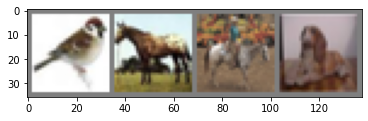

In [43]:
def imshow(img):
    img = img * 0.5 + 0.5  # 去标准化
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

    
# 随机获取一些训练图像
dataiter = iter(trainloader)

# images: torch.Size([4, 3, 32, 32])
# labels: tensor([2, 4, 1, 0])
images, labels = dataiter.next()  

# 显示一些图像
imshow(torchvision.utils.make_grid(images))  # make_grid将若干副图拼成一幅图
# 打印标签
print(' '.join(classes[labels[j]] for j in range(4)))

## 定义一个CNN

In [44]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)  # 这里把输出通道数6变大（比如500）就可以看到后面使用GPU的飞速提升
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # sz after conv1 and pool1: (32 - 5 + 1) / 2 = 14
        # sz after conv2 and pool2: (14 - 5 + 1) / 2 = 5
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [45]:
net = Net()
net

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

## 3. 定义损失函数和优化器

使用交叉熵+惯性SGD

In [46]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 4. 训练神经网络

只需要简单地循环data iterator，将数据不断喂给网络并进行优化

In [47]:
for epoch in range(2):
    
    running_loss = 0.0
    for i, data in enumerate(trainloader):
        inputs, labels = data  # inputs: [4, 3, 32, 32]
        
        # 清空梯度缓存
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # 打印统计
        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[{}, {}] loss: {:.3f}'.format(epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print("Finished Training")

[1, 2000] loss: 2.207
[1, 4000] loss: 1.865
[1, 6000] loss: 1.688
[1, 8000] loss: 1.560
[1, 10000] loss: 1.538
[1, 12000] loss: 1.490
[2, 2000] loss: 1.427
[2, 4000] loss: 1.382
[2, 6000] loss: 1.360
[2, 8000] loss: 1.319
[2, 10000] loss: 1.300
[2, 12000] loss: 1.285
Finished Training


保存训练模型

In [48]:
import os

PATH = "trained_models/cifar_net.pth"
if not os.path.exists(PATH):
    os.mkdir("trained_models")
torch.save(net.state_dict(), PATH)

## 测试网络

cat, ship, ship, plane


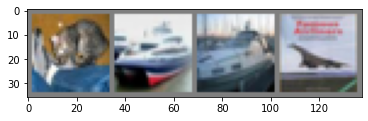

In [49]:
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(', '.join(classes[labels[i]] for i in range(4)))

将训练好的模型加载进来。这里其实无需将训练好的模型加载，只是为了演示。

In [50]:
net = Net()
net.load_state_dict(torch.load(PATH))

outputs = net(images)
values, predicted = torch.max(outputs, 1)
print("Predicted: ", ' '.join(classes[predicted[i]] for i in range(4)))

Predicted:  cat ship ship ship


在整个testset上进行测试

In [51]:
correct = 0
total = 0

with torch.no_grad():  # 测试的时候不能更新参数
    for data in testloader:
        images, labels = data
        outputs = net(images)
        values, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()

print("Accuracy of the network on the 10000 test images: {:.0%}".format(correct / total))

Accuracy of the network on the 10000 test images: 54%


网络似乎学到了一些东西，否则正确率大概是10%。下面我们检查以下那些类别学习得不是很好。

In [52]:
class_correct = [0 for _ in range(10)]
class_total = [0 for _ in range(10)]

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, preds = torch.max(outputs, 1)
        c = (preds == labels)
        for i in range(4):
            label = labels[i]
            class_total[label] += 1
            class_correct[label] += c[i].item()  # 对应的label如果是True就加1，如果是false就加0

for i in range(10):
    print("Accuracy of {}: {:.1%}".format(classes[i], class_correct[i] / class_total[i]))

Accuracy of plane: 60.7%
Accuracy of car: 57.4%
Accuracy of bird: 32.7%
Accuracy of cat: 43.8%
Accuracy of deer: 54.6%
Accuracy of dog: 35.4%
Accuracy of frog: 56.3%
Accuracy of horse: 63.3%
Accuracy of ship: 85.3%
Accuracy of truck: 48.7%


## 在GPU上训练
如果有cuda的话，首先将我们的设备定义成第一个可见的cuda设备。

In [53]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


接下来张量被转换成cuda张量进行加速

In [54]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [55]:
# 训练过程中可以在cmd中输入nvidis-smi查看显卡的使用率，确认是否正在利用GPU训练

for epoch in range(2):
    
    running_loss = 0.0
    for i, data in enumerate(trainloader):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[{}, {}] loss: {:.3f}'.format(epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print("Finished Training")

[1, 2000] loss: 1.251
[1, 4000] loss: 1.256
[1, 6000] loss: 1.254
[1, 8000] loss: 1.255
[1, 10000] loss: 1.259
[1, 12000] loss: 1.281
[2, 2000] loss: 1.251
[2, 4000] loss: 1.263
[2, 6000] loss: 1.243
[2, 8000] loss: 1.265
[2, 10000] loss: 1.265
[2, 12000] loss: 1.270
Finished Training


In [56]:
torch.cuda.is_available()

True